## 1.13 Feature selection

The classes in `sklearn.feature_selection` are used for feature selection and dimensionality reduction, often improving accuracy scores or boosting performance on high-dimensional datasets

### 1.13.1 Removing features with low variance

`VarianceThreshold` is a simple baseline approach to feature selection, removing all features whose variance doesn't meet some specified threshold. By default it removes all zero-variance features

It's based on statistical variance using notation like $Var[X]=p(1-p)$

Example:

In [1]:
from sklearn.feature_selection import VarianceThreshold

In [2]:
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]

sel = VarianceThreshold(0.8 * (1-0.8))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

Note how `VarianceThreshold` removed the first colummn which has probability $p=5/6 > 0.8$ of containing a 0

### 1.13.2 Univariate feature selection

**Univariate feature selection** works by selecting the best features based on univariate statistical tests, and can be seen as a preprocessing step to an estimator. Scikit-learn exposes features selection routines as objects that implement that `transform` method:
* `SelectKBest`
    * removes all but the $k$ highest scoring features
* `SelectPercentile`
    * removes all but a user-specified highest scoring percentage of features
* Common univariate statistical tests for each feature:
    * `SelectFpr` (false positive rate)
    * `SelectFdr` (false discovery rate)
    * `SelectFwe` (family wise error)
* `GenericUnivariateSelect`
    * performs univariate feature selection with a configurable strategy, which lets you select the best univariate strategy with a hyperparameter search estimator

For example, we can perform a $\chi^{2}$ test to the samples to retrieve only the two best features:

In [1]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
X, y = load_iris(return_X_y=True)

X.shape

(150, 4)

In [3]:
X_new = SelectKBest(chi2, k=2).fit_transform(X,y)

X_new.shape

(150, 2)

###### Example - Univariate Feature Selection
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

###### Example - Comparison of F-test and mutual information
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_regression, mutual_info_regression

In [5]:
np.random.seed(0)

X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

In [6]:
f_test = f_regression(X,y)
f_test /= np.max(f_test)

In [7]:
mi = mutual_info_regression(X,y)
mi /= np.max(mi)

IndexError: index 2 is out of bounds for axis 0 with size 2

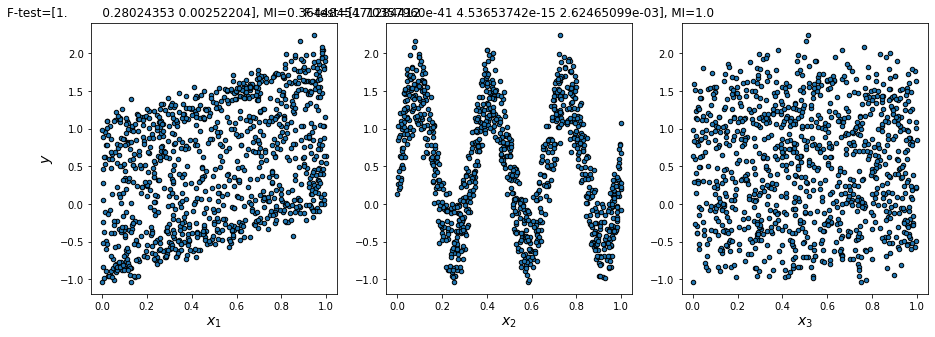

In [10]:
#COPYPASTA
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor="black", s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title(f"F-test={f_test[i]}, MI={mi[i]}")
plt.show()

### 1.13.3 Recursive feature elimination

An external estimator assigns weights to features (coefficients of a linear model), and the goal of recursive feature elimination is to select features by recursively considering smaller sets of features. First the estimator is trained on the initial set of features and the importance of each feature is obtained through a specific attribute or callable.

After that, the least important features are pruned from the current set of features and the procedure is recursively repeated on the pruned set until the desired number of features to select is reached.

###### Example - Recursive feature elimination
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py

In [11]:
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE

In [12]:
digits = load_digits()

X = digits.images.reshape((len(digits.images),-1))
y = digits.target

In [21]:
#create RFE object and rank each pixel
svc = SVC(kernel='linear', C=1)

rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X,y)

ranking = rfe.ranking_.reshape(digits.images[0].shape)

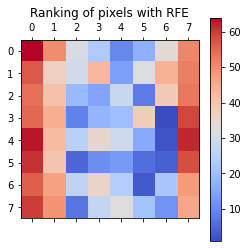

In [24]:
plt.matshow(ranking, cmap='coolwarm')
plt.colorbar()
plt.title('Ranking of pixels with RFE')

plt.show()

###### Example - Recursive feature elimination with cross-validation
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [25]:
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

In [26]:
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

In [27]:
svc = SVC(kernel='linear')

min_features_to_select = 1

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy', min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=SVC(kernel='linear'), scoring='accuracy')

In [28]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


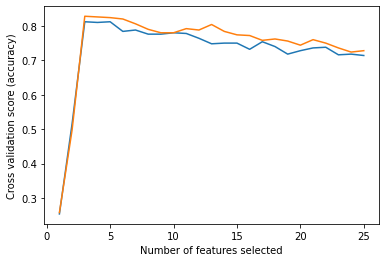

In [29]:
#COPYPASTA
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

### 1.13.4 Feature selection using SelectFromModel

`SelectFromModel` is a meta-transformer. It can be used with any estimator that assigns importance to each feature through a specific attribute (*e.g.* `coef_`,`feature_importances_`) or through the `importance_getter` callable after fitting

Features are removed if the corresponding importance values are below the `threshold` parameter. Available threshold arguments include specifying a number, or heuristics like `mean`, `median`, and float multiples like `0.1 * median`

###### Example - Model-based and sequential feature selection
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py

In [32]:
from sklearn.datasets import load_diabetes

In [33]:
diabetes = load_diabetes()
X,y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [34]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import RidgeCV

In [35]:
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X,y)

importance = np.abs(ridge.coef_)
feature_names = np.array(diabetes.feature_names)

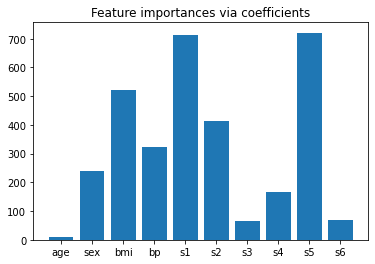

In [36]:
#COPYPASTA
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [37]:
from sklearn.feature_selection import SelectFromModel
from time import time

In [38]:
threshold = np.sort(importance)[-3] + 0.01

tic = time()

sfm = SelectFromModel(ridge, threshold=threshold).fit(X,y)
toc=time

print(f"Features selected: {feature_names[sfm.get_support()]}")

Features selected: ['s1' 's5']


In [39]:
#COPYPASTA
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="forward"
).fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="backward"
).fit(X, y)
toc_bwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)

Features selected by forward sequential selection: ['bmi' 's5']
Done in 0.263s
Features selected by backward sequential selection: ['bmi' 's5']


#### 1.13.4.1 L1-based feature selection

Linear models penalized with the L1 norm have sparse solutions. When the goal is to reduce dimensionality to use with another classifier, they can be used with `SelectFromModel` to select the nonzero coefficients. 

This is particularly good with `Lasso` for regression and with `LogisticRegression` and `LinearSVC` for classification

Example:

In [41]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

In [43]:
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [44]:
lsvc = LinearSVC(C=0.01, penalty='l1', dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)

X_new = model.transform(X)
X_new.shape

(150, 3)

With SVMs (Support Vector Machines) and logistic regression, the parameter $C$ controls the sparsitiy: fewer features are selected for smaller `C`. And for Lasso, controlled by the $\alpha$ parameter, fewer features are selected for a *larger* `alpha`.

###### Example - Classification of text documents using sparse features
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

##### Special note: L1-recovery and compressive setting

For a good choice of alpha, Lasso can fully recover the exact set of nonzero variables using only a few observations, assuming certain conditions are met. For example, the number of samples should be sufficiently large\* or L1 models will perform at random. 

\**Sufficiently large* depends on:
* number of nonzeros
* logarithm of the number of features
* amount of noise
* smallest absolute value of nonzero coefficients
* structure of the design matrix $X$

The design matrix should also have certain properties, like not being too correlated

There's no general for selecting an alpha parameter for recovery of nonzero coefficients. It can be set by cross-validation (`LassoCV` or `LassoLarsCV`) but it might lead to under-penalized models because a small number of non-relevant variables is not detrimental to prediction score

#### 1.13.4.2 Tree-based feature selection

Tree-based estimators can be used to compute impurity-based feature importances, which can then be used to discard irrelevant features when coupled with the `SelectFromModel` meta-transformer

Example:

In [45]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

In [46]:
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [47]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)

clf.feature_importances_

array([0.10881879, 0.05405641, 0.38625807, 0.45086674])

In [49]:
model = SelectFromModel(clf, prefit=True)

X_new = model.transform(X)
X_new.shape

(150, 2)

###### Example - Feature importances with a forest of trees
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

###### Example - Pixel importances with a parallel forest of trees
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-faces-py

In [53]:
import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import RandomForestClassifier

In [54]:
n_jobs = -1

data = fetch_olivetti_faces()
X, y = data.data, data.target

In [55]:
mask = y < 5

X = X[mask]
y = y[mask]

In [56]:
forest = RandomForestClassifier(n_estimators=750, n_jobs=n_jobs, random_state=42)
forest.fit(X,y)

RandomForestClassifier(n_estimators=750, n_jobs=-1, random_state=42)

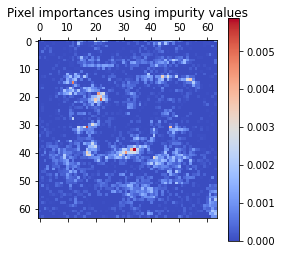

In [60]:
importances = forest.feature_importances_
imp_reshaped = importances.reshape(data.images[0].shape)

plt.matshow(imp_reshaped, cmap='coolwarm')
plt.title('Pixel importances using impurity values')
plt.colorbar()
plt.show()

### 1.13.5 Sequential Feature Selection

**Sequential Feature Selection** is available as a transformer, and can be either forward or backward

**Forward-SFS** is a greedy procedure that iteratively finds the best new feature to add to the set of selected features, starting from 0 features and adding the next best feature with every iteration

**Backward-SFS** works the opposite direction, starting will all features and greedily removing them

In general the forward and backward selections do not yield equivalent results, and one may be faster than the other: if we have 10 features and ask for 7 selected features, forward selection needs 7 iterations and backward selection needs 3 iterations

###### Example - Model-based and sequential feature selection
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py

### 1.13.6 Feature selection as part of a pipeline

Feature selection is usuallly used as a pre-processing step before the actual learning, and the recommended way to do this in scikit-learn is with a `Pipeline`:

```json
clf = Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty='l1'))),
    ('classification', RandomForestClassifier())
])

clf.fit(X, y)
```

You can perform such operations with other feature selection methods and classifiers using `Pipeline`